# Gait steps

Reginaldo K Fukuchi 

This NB implements the "gait_steps.m" Sean Osis method to detect gait events.

In [1]:
# Prepare environment
import os, glob, sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import signal
import scipy.io as spio

%matplotlib inline

from detecta import detect_peaks

import sys
sys.path.insert(1, r'../functions')

### Supporting functions

In [2]:
def f7(seq):
    seen = set()
    seen_add = seen.add
    return [x for x in seq if not (x in seen or seen_add(x))]

def loadjson(filename):
    import json # import library
    with open(fn_json, 'r') as f:
        data = json.load(f)
    
    return data

## Import data
### RIC data

In [3]:
figshare_dir = r'C:\Users\Reginaldo\OneDrive - University of Calgary\data\Figshare_SciData\new_unzip'

In [4]:
fn_json=os.path.join(figshare_dir, '201225', '20140515T133244.json')
data_RIC = loadjson(fn_json)
data_RIC.keys()

dict_keys(['hz_w', 'hz_r', 'walking', 'running', 'joints', 'neutral', 'dv_w', 'dv_r'])

In [5]:
# Create dataframe column corresponding to the dataset
neutral_lbls = list(data_RIC['neutral'].keys())
xyz = list('XYZ')*len(neutral_lbls)
neutral_lbls = [ele for ele in neutral_lbls for i in range(3)]
neutral_lbls = [neutral_lbls[i]+'_'+xyz[i] for i in range(len(xyz))]

# Joint marker labels static trial
joints_lbls = list(data_RIC['joints'].keys())
xyz = list('XYZ')*len(joints_lbls)
joints_lbls = [ele for ele in joints_lbls for i in range(3)]
joints_lbls = [joints_lbls[i]+'_'+xyz[i] for i in range(len(xyz))]

# Marker labels running trial
gait_lbls = list(data_RIC['running'].keys())
xyz = list('XYZ')*len(gait_lbls)
gait_lbls = [ele for ele in gait_lbls for i in range(3)]
gait_lbls = [gait_lbls[i]+'_'+xyz[i] for i in range(len(xyz))]

In [6]:
# Convert dictionaries into pandas dfs
neutral = pd.DataFrame.from_dict(data_RIC['neutral']).values.reshape((1,len(neutral_lbls)),
                                                                     order='F')
joints  = pd.DataFrame.from_dict(data_RIC['joints']).values.reshape((1,len(joints_lbls)),
                                                                     order='F')

In [7]:
# Convert dictionaries into pandas dfs
neutral = pd.DataFrame(data=neutral, 
                           columns=neutral_lbls)
joints = pd.DataFrame(data=joints, 
                           columns=joints_lbls)

In [8]:
run_data = np.empty(shape=(5000, len(list(data_RIC['running'].keys()))*3))
for m, mkr in enumerate(list(data_RIC['running'].keys())):
    run_data[:, 3*m:3*(m+1)] = np.array(data_RIC['running'][mkr])
# Create dataframe with running data
gait = pd.DataFrame(data = run_data, columns=gait_lbls)

### Run gait_kinematics.py

In [9]:
from gait_kinematics import gait_kinematics

In [10]:
# Invoking function to calculate angles
angle_L_ankle, angle_R_ankle, angle_L_knee, angle_R_knee, angle_L_hip, angle_R_hip, angle_L_foot, angle_R_foot, angle_Pelvis = gait_kinematics(joints, neutral, gait, data_RIC['hz_r'])

In [11]:
angle_L_ankle, angle_R_ankle = angle_L_ankle*(180/np.pi), angle_R_ankle*(180/np.pi)
angle_L_knee, angle_R_knee   = angle_L_knee*(180/np.pi), angle_R_knee*(180/np.pi)
angle_L_hip, angle_R_hip     = angle_L_hip*(180/np.pi), angle_R_hip*(180/np.pi)
angle_L_foot, angle_R_foot   = angle_L_foot*(180/np.pi), angle_R_foot*(180/np.pi)
angle_Pelvis  = angle_Pelvis * (180/np.pi)

In [12]:
# Create dataframe column corresponding to the dataset
joints_lbls = ['pelvis','L_foot','R_foot','L_hip','R_hip','L_knee','R_knee',
               'L_ankle','R_ankle']
xyz = list('XYZ')*len(joints_lbls)
joints_lbls = [ele for ele in joints_lbls for i in range(3)]
joints_lbls = [joints_lbls[i]+'_'+xyz[i] for i in range(len(xyz))]

In [13]:
angs = np.hstack([angle_Pelvis, angle_L_foot, angle_R_foot, 
                  angle_L_hip, angle_R_hip, angle_L_knee, angle_R_knee, 
                  angle_L_ankle, angle_R_ankle])
angles = pd.DataFrame(data=angs, columns=joints_lbls)

# Run gait_steps.py

In [14]:
from gait_steps import gait_steps

In [15]:
L_TD, L_TO, R_TD, R_TO, label = gait_steps(neutral, gait, angles, data_RIC['hz_r'])

Automated event detection failed, defaulting to foot-forward foot-back


In [24]:
R_TO

array([ 248.,  379.,  509.,  640.,  771.,  901., 1030., 1161., 1292.,
       1421., 1552., 1683., 1811., 1943., 2075., 2205., 2334., 2465.,
       2598., 2728., 2858., 2989., 3120., 3250., 3380., 3507., 3638.,
       3769., 3901., 4030., 4160., 4290., 4420., 4548., 4679., 4807.,
       4938.])

In [35]:
joints = ['hip','knee','ankle']
axes = ['X','Y','Z']

## Plot angles

In [28]:
rtd = R_TD.astype(int).tolist()
rto = R_TO.astype(int).tolist()

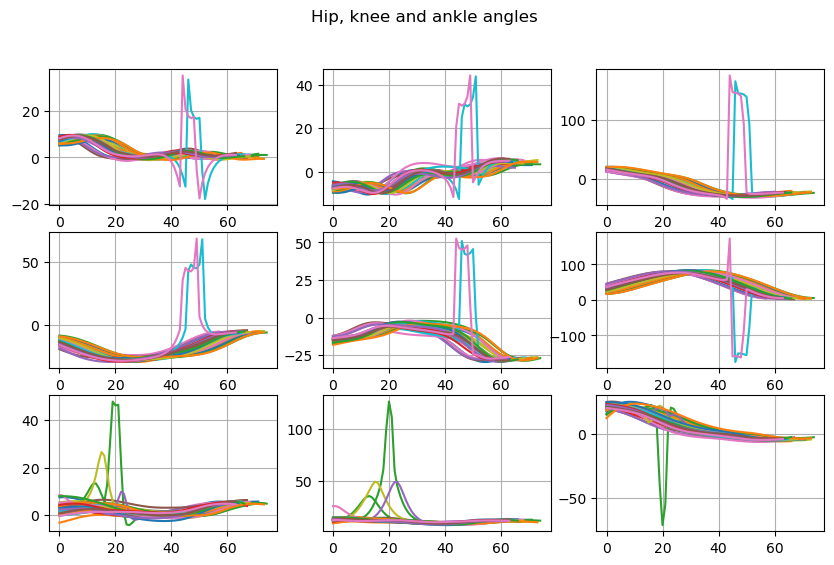

In [37]:
fig, axs = plt.subplots(3,3, figsize=(10,6))
fig.suptitle('Hip, knee and ankle angles')
for j, joint in enumerate(joints):
    ang = angles.filter(like='L_'+joint).values
    for xyz, eixo in enumerate(axes):
        for i in range(len(rtd)):
            axs[j,xyz].plot(ang[rtd[i]:rto[i], xyz])
            axs[j,xyz].grid('on')
plt.show()

In [ ]:
fig, axs = plt.subplots(3, figsize=(10,6))
fig.suptitle('Comparison of LEFT ankle angles between methods')
axs[0].plot(angle_L_ankle[:,0], 'b', label='Python')
axs[0].plot(tn[0::3],anga_matlab[0::3,0], 'b*', label='Matlab')
axs[0].grid('on')
axs[1].plot(angle_L_ankle[:,1], 'r', label='Python')
axs[1].plot(tn[0::3],anga_matlab[0::3,1], 'r*', label='Matlab')
axs[1].grid('on')
axs[2].plot(angle_L_ankle[:,2], 'g', label='Python')
axs[2].plot(tn[0::3],anga_matlab[0::3,2], 'g*', label='Matlab')
axs[2].grid('on')
plt.show()

In [ ]:
from tnorma import tnorma

In [ ]:
ang_hip = np.empty(shape=(101,iTD.shape[0]-1,3))
ang_knee= np.empty(shape=(101,iTD.shape[0]-1,3))
for i in range(iTD.shape[0]-1):
    ang_hip[:,i,:], tn, indie = tnorma(angh_r[iTD[i]:iTD[i+1],:], k=1, 
                                       smooth=0, mask=None, show=False)
    ang_knee[:,i,:], tn, indie= tnorma(angk_r[iTD[i]:iTD[i+1],:], k=1, 
                                       smooth=0, mask=None, show=False)

In [ ]:
fig, axs = plt.subplots(3, figsize=(10,6))
fig.suptitle('Comparison of LEFT ankle angles between methods')
axs[0].plot(angle_L_ankle[:,0], 'b', label='Python')
axs[0].plot(tn[0::3],anga_matlab[0::3,0], 'b*', label='Matlab')
axs[0].grid('on')
axs[1].plot(angle_L_ankle[:,1], 'r', label='Python')
axs[1].plot(tn[0::3],anga_matlab[0::3,1], 'r*', label='Matlab')
axs[1].grid('on')
axs[2].plot(angle_L_ankle[:,2], 'g', label='Python')
axs[2].plot(tn[0::3],anga_matlab[0::3,2], 'g*', label='Matlab')
axs[2].grid('on')
plt.show()

# Script used to write gait_steps.py
Leave in the bottom of the NB in case I need to troubleshoot later.

In [ ]:
## Prepare environment
# import os, sys
# import numpy as np
# import pandas as pd
# #from scipy import signal
# import scipy.io as spio
# import matlab
# import matlab.engine

# from detecta import detect_peaks
# from pca_td import pca_td
# from pca_to import pca_to

# from scipy.signal import butter, lfilter, filtfilt
# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# INPUT PARAMS
# hz = data_RIC['hz_r']
# neutral
# angles
# label
# pathname = r'../data'# Import data

#%% Determine functional measures and gait type (walk vs run)
# % movement speed comes from the A/P position time history of a heel marker
# % so we first need to identify a heel marker
# LEFT SIDE
# Determine functional measures and gait type (walk vs run) movement speed comes 
# from the A/P position time history of a heel marker so we first need to identify 
# a heel marker.

# % Combine 3 of the foot markers into one matrix (ignore the created fourth)
L_foot = neutral[['L_foot_1_X', 'L_foot_1_Y', 'L_foot_1_Z',
              'L_foot_2_X', 'L_foot_2_Y', 'L_foot_2_Z',
              'L_foot_3_X', 'L_foot_3_Y', 'L_foot_3_Z']].values.reshape((3,3))
# sort the markers from left to right
i_lf   = list(L_foot[:, 0].argsort())
L_foot = L_foot[L_foot[:, 0].argsort()]

# find the lower of the two medial markers
if L_foot[1,1] < L_foot[2,1]:
    L_marker = 'L_foot_' + str(i_lf[1]+1)
    L_heel =  gait.filter(like=L_marker).values
else:
    L_marker = 'L_foot_' + str(i_lf[2]+1)
    L_heel =  gait.filter(like=L_marker).values
    
# Find peaks location. Signal flipped because of X-axis convention difference.
locs0 = detect_peaks(np.diff(L_heel[:,2]), mpd=np.round(0.5*hz), 
                    mph=0, show=False)
pks = np.diff(L_heel[:,2])[locs0]

locs = detect_peaks(-np.diff(L_heel[:,2]), mpd=np.round(0.5*hz), 
                    mph=0, show=False)

# Gait velocity and cadence
vel    = hz*np.median(pks)/1000; # gait speed
stRate = 60/(np.median(np.diff(locs))/hz); # cadence
#print('Gait velocity is '+str(vel)+' m/s')
#print('Stride rate is '+str(stRate)+' strides/min')

#%% RIGHT SIDE
# % Combine 3 of the foot markers into one matrix (ignore the created fourth)
R_foot = neutral[['R_foot_1_X', 'R_foot_1_Y', 'R_foot_1_Z',
              'R_foot_2_X', 'R_foot_2_Y', 'R_foot_2_Z',
              'R_foot_3_X', 'R_foot_3_Y', 'R_foot_3_Z']].values.reshape((3,3))
# sort the markers from left to right
i_rf   = list(R_foot[:, 0].argsort())
R_foot = R_foot[R_foot[:, 0].argsort()]

# find the lower of the two medial markers
if R_foot[0,1] < R_foot[1,1]:
    R_marker = 'R_foot_' + str(i_rf[0]+1)
    R_heel =  gait.filter(like=R_marker).values
else:
    R_marker = 'R_foot_' + str(i_rf[1]+1)
    R_heel =  gait.filter(like=R_marker).values
    
# Linear discriminant analysis
# Import training dataset
gaitClass = pd.read_csv(os.path.join(r'../data', 'LDA_out.txt'), delimiter='\t', 
                        header=None, names=['Category','Speed','Cadence'], usecols=[0,1,2])
# Replace numerical by categorical
gaitClass['Category'] = gaitClass['Category'].replace(1, 'walk')
gaitClass['Category'] = gaitClass['Category'].replace(2, 'run')

# Input to the model
X = gaitClass[['Speed','Cadence']].values # training data
y = gaitClass['Category'].values.tolist() # testing data
model = LinearDiscriminantAnalysis()# define model
model.fit(X, y) # Model fit

# make a prediction
label = model.predict(np.array([vel,stRate]).reshape((1,2)))[0]
#print('Gait category is '+label)

# Load PCA output from mat file
# % event_data is a .mat file containing 'coeff' which is the coefficients
# % from the pre-trained PCA and 'p' which is the list of coefficients of the
# % linear polynomial relating PCA scores with touchdown timing relative to
# % the foot acceleration peak.
event_data_TD = spio.loadmat(os.path.join(r'../data', 'event_data_TD.mat'))
event_data_TO = spio.loadmat(os.path.join(r'../data', 'event_data_TO.mat'))

#%% Identify Touch Down and Take Off events: Gait Independent
# % Use PCA touchdown detection based on updated Osis et al. (2014) for
# % both walking and running.
# % Use new PCA toeoff detection for both walking and running.
# % evt variables are NOT rounded
try:
    evtLtd, evtRtd = pca_td(angles, hz, event_data_TD, label)
    evtLto, evtRto = pca_to(angles, hz, event_data_TO, label)
    
except Exception as e: 
    #For a small number of people, these functions return errors, or in the
    #case of bad data... default to use FF and FB in these cases
    
    evtRtd = []
    evtRto = []
    
    print('Automated event detection failed, defaulting to foot-forward foot-back')
    print(e)
    
## LEFT FOOT EVENTS
# % when the feet are not tracked very well, discontinuities in the heel
# % marker can occur causing the findpeaks to pick up additional 'peaks'
# % for the purposes of simply identifying foot forward and foot back
# % timing, we can over filter this signal. We do not care about the
# % magnitude of the signal but only the timing so we can overfit as long
# % as the filter has a zero phase shift.
# % Note: signal is now filtered by default.  There is no advantage to not
# % filtering, as if the signal quality is already good, then the system uses
# % PCA event detection anyhow, and if the signal is bad, then it has to be
# % filtered in order to get foot-forward foot-backward events.

# Correct the cutoff frequency for the number of passes in the filter
b, a = butter(2, 5/(hz/2), btype = 'low')
# note that Python and Matlab filtfilt behaves slightly different with padding the data
# see https://mail.python.org/pipermail/scipy-user/2014-April/035646.html
filtered_L_heel = filtfilt(b, a, L_heel[:,2], padtype='odd')

# Begin by creating a gross estimation of foot forwards and foot backs
L_FFi = detect_peaks(-filtered_L_heel, mpd=np.round(0.35*hz),
                     show=False)

if label == 'walk':
    # % Use peak foot flexion angle for foot back
    # % To deal with peaks resulting from signal flipping, threshold them
    angSig = angles['L_foot_Z'].values
    angSig[np.abs(angSig) > 90] = np.NaN
    L_FBi = detect_peaks(-angSig, mpd=np.round(0.7*hz),
                     mph=20, show=False)
else:
    # Use rearmost position of heel marker for foot back
    L_FBi = detect_peaks(filtered_L_heel, mpd=np.round(0.35*hz),
                     show=False)
    
# %Uncomment block below to enable more aggressive quality control of data

# if (np.nanpercentile(np.abs(angles['foot_Z'].values), 90) > 120) & vel < 4
#     print('Right ankle values outside of expected ranges, please ensure your shoe markers are properly placed and redo your collection')
#     sys.exit()

# Remove any leading FB
L_FBi = L_FBi[L_FBi>L_FFi[0]]

## find largest chunk of continuous data

#We want to check before and after that there is sufficient data for analysis

if (L_FFi.shape[0] < 2) or (L_FBi.shape[0] < 2):
    print('Automated event detection unable to pull adequate number of strides for analysis. Please redo your data collection.')
    sys.exit()
    
# Call Matlab function LARGEST_BLOCK.m from Python
eng = matlab.engine.start_matlab() # start Matlab engine
eng.cd(r'../functions', nargout=0) # set path for functions dir


L_FFi, L_FBi, L_block_start, block_end = eng.largest_block(matlab.double(list(L_FFi)), 
                                                             matlab.double(list(L_FBi)), nargout=4)

L_FFi = np.array(L_FFi).flatten().astype(int)
L_FBi = np.array(L_FBi).flatten().astype(int)

if (L_FFi.shape[0] < 2) or (L_FBi.shape[0] < 2):
    print('Automated event detection unable to pull adequate number of strides for analysis. Please redo your data collection.')
    sys.exit()
    
# TOUCHDOWN
# evtLtd from above

# SELECT SEQUENTIAL STEPS
# create an ordered set of sequential steps using FFi as guide
closest = np.abs(np.repeat(L_FFi[:,np.newaxis], evtLtd.shape[0], axis=1)-np.repeat(evtLtd[:,np.newaxis].T, L_FFi.shape[0], axis=0))

mindist, minx = np.nanmin(closest, axis=0), np.nanargmin(closest, axis=0)

for i in np.unique(minx).astype(int):
    if np.sum(np.isin(i,minx)) > 1:
        mindist = mindist[minx!=i]
        evtLtd  = evtLtd[minx!=i]
        minx    = minx[minx!=i]
        
# Parameter based on the typical frame adjustments observed in 300
# datasets
if label=='run':
    maxadj = 0.05*hz
else:
    maxadj = 0.10*hz
    
# Preallocate
L_TD = np.empty(L_FFi.shape[0]) * np.NaN
evFltd = np.zeros(L_FFi.shape[0])

# Here we replace FF indices with indices from evt where criteria are
# met... the default is to use FF
for i in range(L_FFi.shape[0]):
    try:
        if i > np.max(minx):
            break
        elif np.isin(i,minx) and mindist[minx==i] < maxadj:
            #Replace with evtLtd since its more accurate
            L_TD[i] = evtLtd[minx==i]
            evFltd[i] = 1
        else:
            #Use FFi since it is more robust
            L_TD[i] = L_FFi[i]
            
    except Exception as e:
        print(e)
        L_TD[i] = L_FFi[i]
        
# %% TAKEOFF

# % evtLto from above

# % SELECT SEQUENTIAL STEPS

# % Now create an ordered set of sequential steps using FBi as guide
closest = np.abs(np.repeat(L_FBi[:,np.newaxis], evtLto.shape[0], axis=1)-np.repeat(evtLto[:,np.newaxis].T, L_FBi.shape[0], axis=0))

mindist, minx = np.nanmin(closest, axis=0), np.nanargmin(closest, axis=0)
for i in np.unique(minx).astype(int):
    if np.sum(np.isin(i,minx)) > 1:
        mindist = mindist[minx!=i]
        evtLtd  = evtLtd[minx!=i]
        minx    = minx[minx!=i]
        
# Parameter based on the frame adjustment observed from 300 datasets
maxadj = 0.15*hz

# Preallocate
L_TO = np.empty(L_FBi.shape[0]) * np.NaN
evFlto = np.zeros(L_FBi.shape[0])

# Here we replace FB indices with TO from PCA default is to use FB
for i in range(L_FBi.shape[0]):
    try:
        if i > np.max(minx):
            break
        elif np.isin(i,minx) and mindist[minx==i] < maxadj:
            #Replace with evtLto since its more accurate
            L_TO[i] = evtLto[minx==i]
            evFlto[i] = 1
        else:
            #Use FFi since it is more robust
            L_TO[i] = L_FBi[i]
            
    except Exception as e:
        print(e)
        L_TO[i] = L_FBi[i]

# Finally we round to get final indices
L_TD = L_TD.round()
L_TO = L_TO.round()


# %% RIGHT FOOT EVENTS
# % the same steps we just took for the left side

# % Begin by creating a gross estimation of foot forwards and foot backs
# Correct the cutoff frequency for the number of passes in the filter
b, a = butter(2, 5/(hz/2), btype = 'low')
# note that Python and Matlab filtfilt behaves slightly different with padding the data
# see https://mail.python.org/pipermail/scipy-user/2014-April/035646.html
filtered_R_heel = filtfilt(b, a, R_heel[:,2], padtype='odd')

# Begin by creating a gross estimation of foot forwards and foot backs
R_FFi = detect_peaks(-filtered_R_heel, mpd=np.round(0.35*hz),
                     show=False)

if label == 'walk':
    # % Use peak foot flexion angle for foot back
    # % To deal with peaks resulting from signal flipping, threshold them
    angSig = angles['R_foot_Z'].values
    angSig[np.abs(angSig) > 90] = np.NaN
    R_FBi = detect_peaks(-angSig, mpd=np.round(0.7*hz),
                     mph=20, show=False)
else:
    # Use rearmost position of heel marker for foot back
    R_FBi = detect_peaks(filtered_R_heel, mpd=np.round(0.35*hz),
                     show=False)
    
# %Uncomment block below to enable more aggressive quality control of data

# if (np.nanpercentile(np.abs(angles['R_foot_Z'].values), 90) > 120) & vel < 4
#     print('Right ankle values outside of expected ranges, please ensure your shoe markers are properly placed and redo your collection')
#     sys.exit()

# Remove any leading FB
R_FFi = R_FFi[R_FFi>L_FFi[0]]
R_FBi = R_FBi[R_FBi>R_FFi[0]]

## find largest chunk of continuous data

#We want to check before and after that there is sufficient data for analysis

if (R_FFi.shape[0] < 2) or (R_FBi.shape[0] < 2):
    print('Automated event detection unable to pull adequate number of strides for analysis. Please redo your data collection.')
    sys.exit()
    
    
# LARGEST_BLOCK
R_FFi, R_FBi, R_block_start, R_block_end = eng.largest_block(matlab.double(list(R_FFi)), 
                                                             matlab.double(list(R_FBi)), nargout=4)

R_FFi = np.array(R_FFi).flatten().astype(int)
R_FBi = np.array(R_FBi).flatten().astype(int)

if (R_FFi.shape[0] < 2) or (R_FBi.shape[0] < 2):
    print('Automated event detection unable to pull adequate number of strides for analysis. Please redo your data collection.')
    sys.exit()
    
# %In rare instances a the index will be in incorrect order run below again
# %in case

# % Remove any leading FF and FB
R_FFi = R_FFi[R_FFi>L_FFi[0]]
R_FBi = R_FBi[R_FBi>R_FFi[0]]

# TOUCHDOWN
# evtRtd from above

# SELECT SEQUENTIAL STEPS
# create an ordered set of sequential steps using FFi as guide
closest = np.abs(np.repeat(R_FFi[:,np.newaxis], evtRtd.shape[0], axis=1)-np.repeat(evtRtd[:,np.newaxis].T, R_FFi.shape[0], axis=0))

mindist, minx = np.nanmin(closest, axis=0), np.nanargmin(closest, axis=0)

for i in np.unique(minx).astype(int):
    if np.sum(np.isin(i,minx)) > 1:
        mindist = mindist[minx!=i]
        evtLtd  = evtLtd[minx!=i]
        minx    = minx[minx!=i]
        
# Parameter based on the typical frame adjustments observed in 300
# datasets
if label=='run':
    maxadj = 0.05*hz
else:
    maxadj = 0.10*hz
    
# Preallocate
R_TD = np.empty(R_FFi.shape[0]) * np.NaN
evFrtd = np.zeros(R_FFi.shape[0])

# Here we replace FF indices with indices from evt where criteria are
# met... the default is to use FF
for i in range(R_FFi.shape[0]):
    try:
        if i > np.max(minx):
            break
        elif np.isin(i,minx) and mindist[minx==i] < maxadj:
            #Replace with evtRtd since its more accurate
            R_TD[i] = evtRtd[minx==i]
            evFrtd[i] = 1
        else:
            #Use FFi since it is more robust
            R_TD[i] = R_FFi[i]
            
    except Exception as e:
        print(e)
        R_TD[i] = R_FFi[i]
        
        
# %% TAKEOFF

# % evtRto from above

# % SELECT SEQUENTIAL STEPS

# % Now create an ordered set of sequential steps using FBi as guide
closest = np.abs(np.repeat(R_FBi[:,np.newaxis], evtRto.shape[0], axis=1)-np.repeat(evtRto[:,np.newaxis].T, R_FBi.shape[0], axis=0))

mindist, minx = np.nanmin(closest, axis=0), np.nanargmin(closest, axis=0)
for i in np.unique(minx).astype(int):
    if np.sum(np.isin(i,minx)) > 1:
        mindist = mindist[minx!=i]
        evtLtd  = evtLtd[minx!=i]
        minx    = minx[minx!=i]
        
# Parameter based on the frame adjustment observed from 300 datasets
maxadj = 0.15*hz

# Preallocate
R_TO = np.empty(R_FBi.shape[0]) * np.NaN
evFrto = np.zeros(R_FBi.shape[0])

# Here we replace FB indices with TO from PCA default is to use FB
for i in range(R_FBi.shape[0]):
    try:
        if i > np.max(minx):
            break
        elif np.isin(i,minx) and mindist[minx==i] < maxadj:
            #Replace with evtLto since its more accurate
            R_TO[i] = evtRto[minx==i]
            evFrto[i] = 1
        else:
            #Use FFi since it is more robust
            R_TO[i] = R_FBi[i]
            
    except Exception as e:
        print(e)
        R_TO[i] = R_FBi[i]

# Finally we round to get final indices
R_TD = R_TD.round()
R_TO = R_TO.round()

# %% if largest chunk of continuous data not at beginning, chop both right and left so they match


# %index must begin with left touchdown and end with right toe
# %off


if R_block_start < L_block_start:
    #remove all right indices that occur before the first left touchdown
    
    R_TO = R_TO[(R_TD < L_block_start)!=1]
    R_TD = R_TD[(R_TD < L_block_start)!=1]
    
flag = 0

if L_block_start < R_block_start:
    #remove left touchdowns more than one touchdown before the first right touchdown
    cut_inds = (L_TD<R_block_start)==1
    cut_inds.astype(int)
    #this loop ensures the first index will be a left touchdown
    for i in range(cut_inds.shape[0]):
        if (cut_inds[i]==1) and (cut_inds[i+1]==0) and flag==0:
            cut_inds[i] = 0
            flag = 1
            
    L_TD = np.delete(L_TD, cut_inds)
    L_TO = np.delete(L_TO, cut_inds)
    
    
# create an events matrix
# Remove trailing nans that may have crept in
evFltd = evFltd[~np.isnan(L_TD)]
evFlto = evFlto[~np.isnan(L_TO)]
evFrtd = evFrtd[~np.isnan(R_TD)]
evFrto = evFrto[~np.isnan(R_TO)]

L_TD = L_TD[~np.isnan(L_TD)]
L_TO = L_TO[~np.isnan(L_TO)]
R_TD = R_TD[~np.isnan(R_TD)]
R_TO = R_TO[~np.isnan(R_TO)]

# Find the closest ordered pairs of L_TO and R_TD to synchronize steps
closest = np.abs(np.repeat(R_TD[:,np.newaxis], L_TO.shape[0], axis=1)-np.repeat(L_TO[:,np.newaxis].T, R_TD.shape[0], axis=0))

minx = np.nanargmin(closest,axis=0)

#Truncate right stances to match up with left
evFrtd = evFrtd[np.unique(minx)]
R_TD = R_TD[np.unique(minx)]


testlength = np.min([L_TO.shape[0], R_TD.shape[0]])
if np.median(L_TO[:testlength]-R_TD[:testlength]) < 0:#Then there is a flight phase
    #Find the closest ordered pairs of R_TD and R_TO to synchronize steps
    closest = np.abs(np.repeat(R_TO[:,np.newaxis], R_TD.shape[0], axis=1)-np.repeat(R_TD[:,np.newaxis].T, R_TO.shape[0], axis=0))
    minx = np.nanargmin(closest,axis=0)
    
else: # There is no flight phase i.e. grounded running or walking
    #Find the closest ordered pairs of R_TO and L_TD to synchronize steps
    tmp = L_TD[1:]
    closest = np.abs(np.repeat(R_TO[:,np.newaxis], tmp.shape[0], 
                               axis=1)-np.repeat(tmp[:,np.newaxis].T, R_TO.shape[0], axis=0))
    minx = np.nanargmin(closest,axis=0)
    
evFrto = evFrto[np.unique(minx)]
R_TO = R_TO[np.unique(minx)]

events = [L_TD.shape[0], L_TO.shape[0], R_TD.shape[0], R_TO.shape[0]]

# Chop everything to the same length
L_TD = L_TD[:min(events)]
L_TO = L_TO[:min(events)]
R_TD = R_TD[:min(events)]
R_TO = R_TO[:min(events)]

evFltd = evFltd[:min(events)]
evFlto = evFlto[:min(events)]
evFrtd = evFrtd[:min(events)]
evFrto = evFrto[:min(events)]

# Very rarely, these will wind up empty and assignment doesn't work
events = np.empty(shape=(L_TD.shape[0],4)) * np.NaN
events[:,0]=L_TD
events[:,1]=L_TO
events[:,2]=R_TD
events[:,3]=R_TO
# Very rarely, these will wind up empty and assignment doesn't work
eventsflag = np.empty(shape=(evFltd.shape[0],4)) * np.NaN
eventsflag[:,0]=evFltd
eventsflag[:,1]=evFlto
eventsflag[:,2]=evFrtd
eventsflag[:,3]=evFrto

# Remove first row since these will very often be reliant on FF and FB measures
if events.shape[0] > 1:
    events = np.delete(events,0,axis=0)
    eventsflag = np.delete(eventsflag,0,axis=0)
    
# %% Occasionally, one stance will drop out, and data becomes
# % discontinuous...this fix alleviates this by trimming data to largest
# % continuous block
try:
    cont = np.array([events[1:,0]>events[:-1,1],events[1:,2]>events[:-1,3]])
    cont = np.hstack((np.zeros((2,1)),cont,np.zeros((2,1)))).T
    F = np.where(np.any(cont==0, axis=1))
    F = np.asarray(F).flatten()
    D = np.diff(F)-2
    M, L = np.max(D), np.argmax(D)
    events = events[F[L]:F[L]+M+1,:]
    eventsflag = eventsflag[F[L]:F[L]+M+1,:]
except Exception as e:
    print('Could not obtain a continuous block of events')
    events = []
    eventsflag = []
    print(e)
    
# Worst-case... return to foot forward, foot back detection
if events.shape[0] < 5:
    print('Automated event detection failed, defaulting to foot-forward foot-back')
    nevents = [L_FFi.shape[0], L_FBi.shape[0], R_FFi.shape[0], R_FBi.shape[0]]
    
    # Chop everything to the same length
    L_FFi = L_FFi[:min(nevents)]
    L_FBi = L_FBi[:min(nevents)]
    R_FFi = R_FFi[:min(nevents)]
    R_FBi = R_FBi[:min(nevents)]
    
    events = np.empty(shape=(min(nevents),4)) * np.NaN
    events[:,0] = L_FFi
    events[:,1] = L_FBi
    events[:,2] = R_FFi
    events[:,3] = R_FBi
    
# Pull event columns from events so everything is consistent
L_TD = events[:,0]
L_TO = events[:,1]
R_TD = events[:,2]
R_TO = events[:,3]

In [ ]:
L_TD

In [ ]:
L_TDm

In [ ]:
L_TO

In [ ]:
L_TOm

In [ ]:
R_TD

In [ ]:
R_TDm

## Compare outputs between gait_steps.m and gait_steps.py

In [ ]:
# Invoking function to calculate angles
#angle_L_ankle, angle_R_ankle, angle_L_knee, angle_R_knee, angle_L_hip, angle_R_hip, angle_L_foot, angle_R_foot, angle_Pelvis = gait_kinematics(joints, neutral, gait, data_RIC['hz_r'])

In [ ]:
'L_ankle','R_ankle','L_knee','R_knee','L_hip','R_hip','L_foot','R_foot','pelvis'

In [ ]:
angles_dict = dict()
angles_dict['L_ankle'] = angle_L_ankle
angles_dict['R_ankle'] = angle_R_ankle
angles_dict['L_knee']  = angle_L_knee
angles_dict['R_knee']  = angle_R_knee
angles_dict['L_hip']   = angle_L_hip
angles_dict['R_hip']   = angle_R_hip
angles_dict['L_foot']  = angle_L_foot
angles_dict['R_foot']  = angle_R_foot
angles_dict['pelvis']  = angle_Pelvis

In [ ]:
data_RIC['hz_r']

In [ ]:
matlab.double(float(data_RIC['hz_r']))

In [ ]:
# Call Matlab function gait_steps.m from Python
norm_ang, norm_vel, events, event, dvs, vel, eventsflag, label = eng.gait_steps(data_RIC['neutral'], 
                                                        data_RIC['running'], 
                                                        angles_dict, angles_dict,
                                                        data_RIC['hz_r'],0,
                                                        nargout=8)

In [ ]:
#[norm_ang,norm_vel,events,event,DISCRETE_VARIABLES,speedoutput,eventsflag,label] = gait_steps(neutral,dynamic,angles,velocities,hz,plots)